<a href="https://colab.research.google.com/github/MiltosTsir/supply-chain-analysis-portfolio/blob/main/portfolio/01-demand-forecasting/notebooks/01_eda_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Setup: installs and imports ---
!pip -q install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option("display.max_columns", None)



In [6]:
# --- Load data from GitHub RAW URL ---
RAW_URL = "https://raw.githubusercontent.com/MiltosTsir/supply-chain-analysis-portfolio/main/portfolio/01-demand-forecasting/data/raw/mock_kaggle.csv"

# Read CSV and parse the 'data' column as datetime
df = pd.read_csv(RAW_URL, parse_dates=["data"])
df = df.sort_values("data").reset_index(drop=True)

print("Shape:", df.shape)
df.head()


Shape: (937, 4)


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [7]:
# --- Basic Exploratory Data Aanalysis ---

# General info about the dataset
print(df.info())
print("\n--- Descriptive statistics ---")
print(df.describe(include="all"))

# Check for missing values
print("\n--- Missing values per column ---")
print(df.isna().sum())

# Quick preview of the first rows
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     937 non-null    datetime64[ns]
 1   venda    937 non-null    int64         
 2   estoque  937 non-null    int64         
 3   preco    937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB
None

--- Descriptive statistics ---
                                data       venda      estoque       preco
count                            937  937.000000   937.000000  937.000000
mean   2015-04-19 12:23:49.242262528   90.533618  1608.258271    1.592572
min              2014-01-01 00:00:00    0.000000     0.000000    0.000000
25%              2014-08-29 00:00:00   33.000000   794.000000    1.290000
50%              2015-04-20 00:00:00   76.000000  1348.000000    1.390000
75%              2015-12-10 00:00:00  127.000000  1964.000000    1.890000
m

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


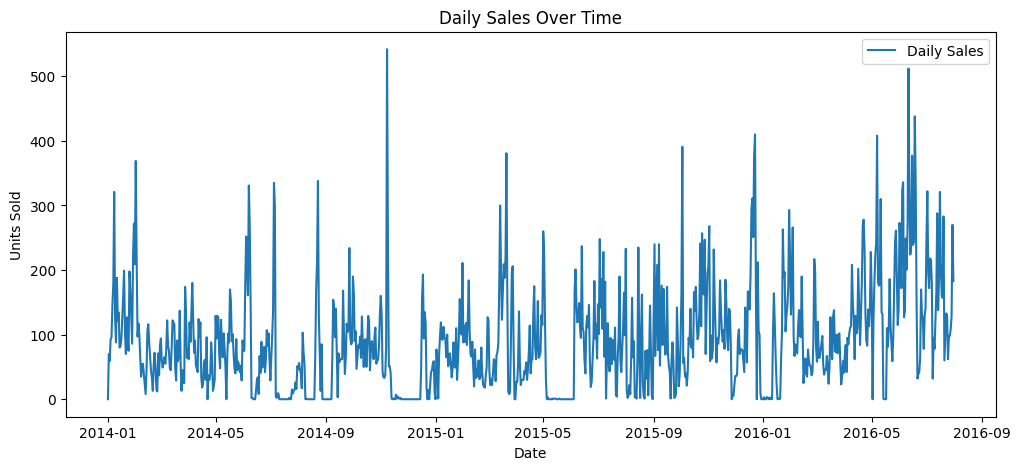

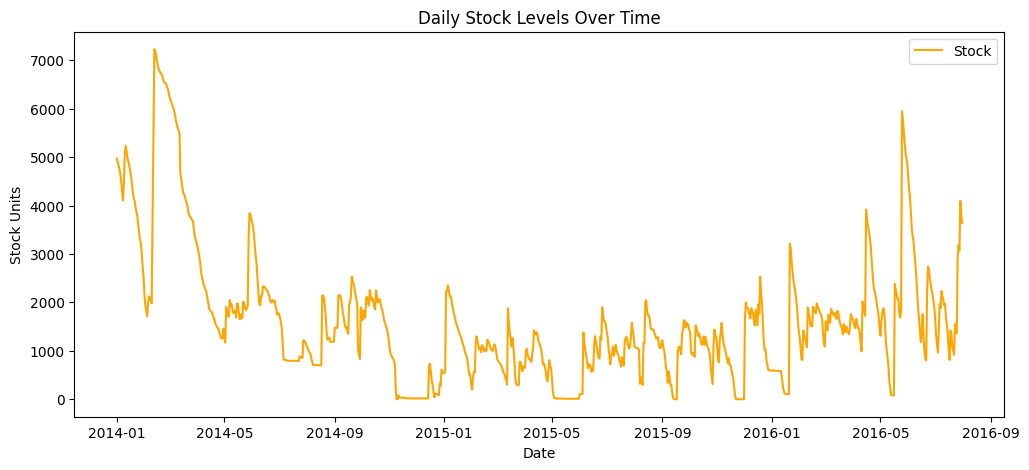

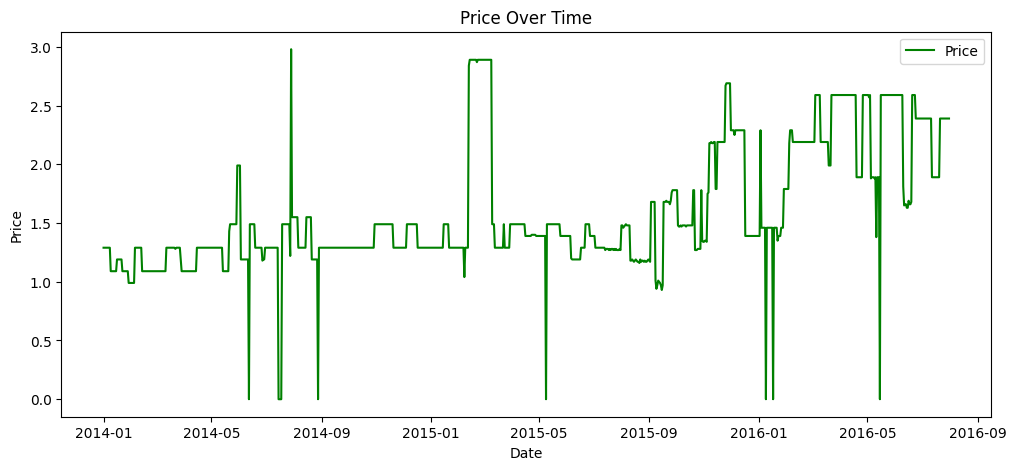

In [8]:
# --- Sales over time (total) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["data"], df["venda"], label="Daily Sales")
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

# --- Stock levels over time ---
plt.figure(figsize=(12,5))
plt.plot(df["data"], df["estoque"], color="orange", label="Stock")
plt.title("Daily Stock Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Units")
plt.legend()
plt.show()

# --- Price over time ---
plt.figure(figsize=(12,5))
plt.plot(df["data"], df["preco"], color="green", label="Price")
plt.title("Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


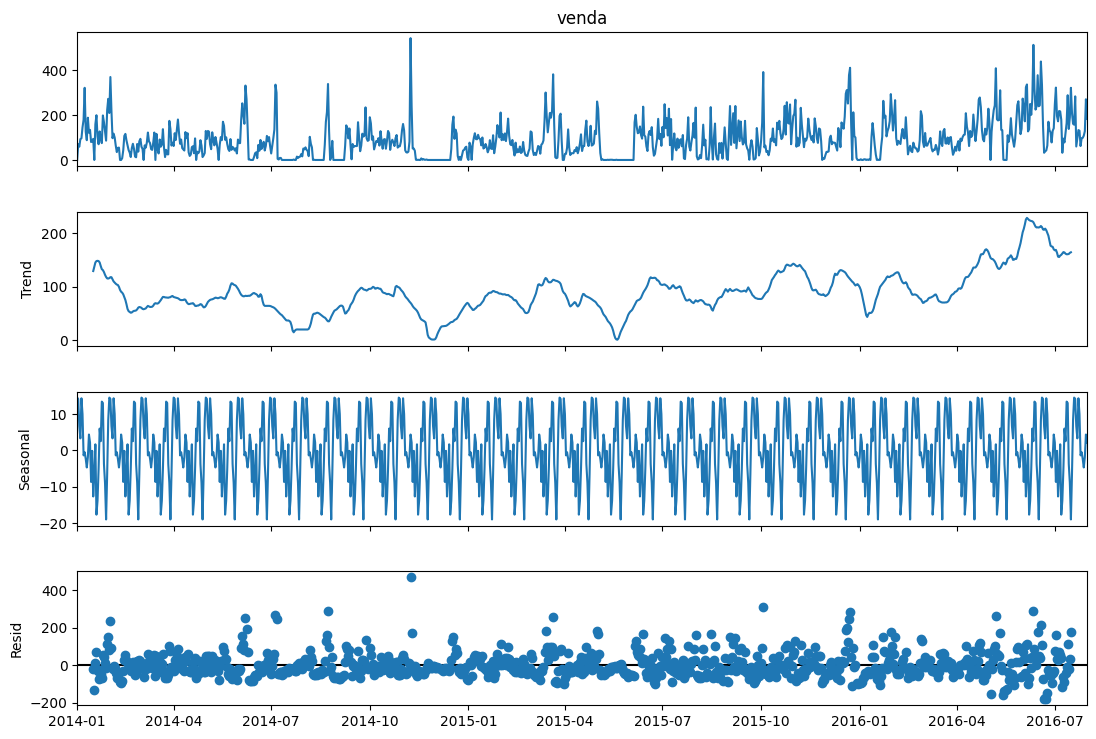

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Create a daily time series indexed by 'data'
ts = df.set_index("data")["venda"].asfreq("D").fillna(0)

# Decompose the time series into trend, seasonality, residual
# period=30 assumes monthly seasonality, can also try 7 (weekly)
result = seasonal_decompose(ts, model="additive", period=30)

fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()


Naive MAPE: 55.15%
MA(7)  MAPE: 77.34%


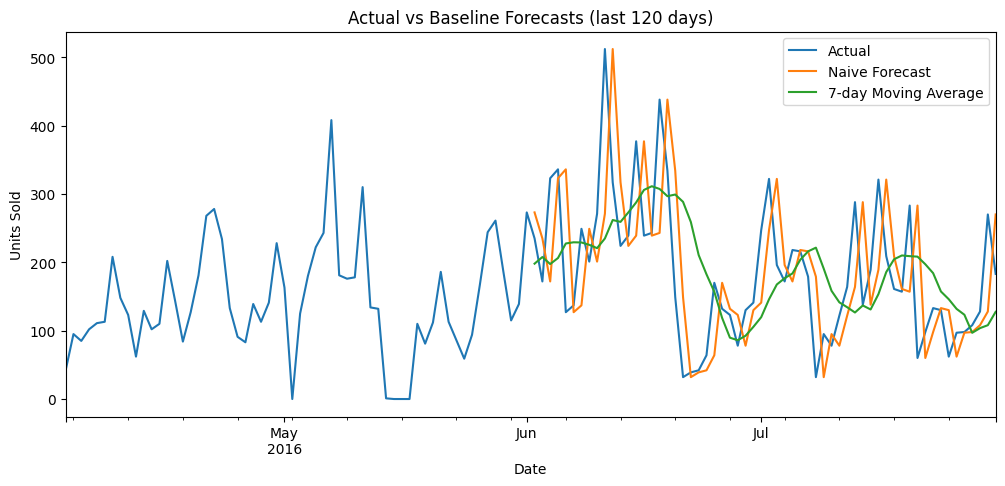

In [10]:
import numpy as np

# Use the same time series as before
ts = df.set_index("data")["venda"].asfreq("D").fillna(0)

# Train/Test split: last 60 days for testing
horizon = 60 if len(ts) > 120 else max(1, len(ts) // 5)
train, test = ts.iloc[:-horizon], ts.iloc[-horizon:]

# --- Baseline Models ---
# Naive: yesterday's value
naive_forecast = ts.shift(1).iloc[-horizon:]

# Moving Average (7 days), shifted so it doesn't peek into the future
ma7 = ts.rolling(7).mean().shift(1).iloc[-horizon:]

# --- Evaluation function ---
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1, y_true)  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

print(f"Naive MAPE: {mape(test, naive_forecast):.2f}%")
print(f"MA(7)  MAPE: {mape(test, ma7):.2f}%")

# --- Plot last 120 days ---
plt.figure(figsize=(12,5))
ts.iloc[-120:].plot(label="Actual")
naive_forecast.iloc[-120:].plot(label="Naive Forecast")
ma7.iloc[-120:].plot(label="7-day Moving Average")
plt.title("Actual vs Baseline Forecasts (last 120 days)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()
